In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumCircuit, Aer, execute, transpile, assemble, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit import IBMQ

In [2]:
def QFTd(n): #source: qiskit
    circuit = QuantumCircuit(n)
    for bit in range(n//2):
        circuit.swap(bit,n-bit-1)
    for j in range(n):
        for m in range(j):
            circuit.cp(-np.pi/(2**(j-m)), m, j) 
            #rotate by -pi/2^(j-m) on the bit j (target), which is controlled by each less significant bit m
        circuit.h(j)
    circuit.name = "QFT"
    return circuit


In [3]:
power2 = 4
global power2
N = 2**power2 - 1

def powermodp2(power): #controlled multiplication by 2^p (modulo 2^n-1)
    global power2
    U = QuantumCircuit(power2)
    for i in range(power):
        for j in range(power2-1):
            U.swap(j,j+1)
    U = U.to_gate()
    U.name = "5^"+str(power)+" mod "+str(33)
    c_U = U.control()
    return c_U

nbits = power2 - 1
xreg = QuantumRegister(nbits,"input")
y = QuantumRegister(power2,"y")
cx = ClassicalRegister(nbits)
qc = QuantumCircuit(xreg,y,cx)

qc.h(xreg[:])
qc.x(nbits + power2 - 1)
for k in range(nbits):
    qc.append(powermodp2(2**k),[k] + y[:])
qc.append(QFTd(nbits),range(nbits))

qc.measure(range(nbits),range(nbits))
#qc = qc.decompose()
qc.draw(fold=-1)


┌───┐                                             ┌──────┐┌─┐      
input_0: ┤ H ├───────■─────────────────────────────────────┤0     ├┤M├──────
         ├───┤       │                                     │      │└╥┘┌─┐   
input_1: ┤ H ├───────┼──────────────■──────────────────────┤1 QFT ├─╫─┤M├───
         ├───┤       │              │                      │      │ ║ └╥┘┌─┐
input_2: ┤ H ├───────┼──────────────┼──────────────■───────┤2     ├─╫──╫─┤M├
         └───┘┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐└──────┘ ║  ║ └╥┘
    y_0: ─────┤0            ├┤0            ├┤0            ├─────────╫──╫──╫─
              │             ││             ││             │         ║  ║  ║ 
    y_1: ─────┤1            ├┤1            ├┤1            ├─────────╫──╫──╫─
              │  5^1 mod 33 ││  5^2 mod 33 ││  5^4 mod 33 │         ║  ║  ║ 
    y_2: ─────┤2            ├┤2            ├┤2            ├─────────╫──╫──╫─
         ┌───┐│             ││             ││             │         ║  ║  ║ 
    y_3: ┤ X ├┤3            ├┤3            ├┤3            ├─────────╫──╫──╫─
         └───┘└─────────────┘└─────────────┘└─────────────┘         ║  ║  ║ 
   c0: 3/═══════════════════════════════════════════════════════════╩══╩══╩═
                                                                    0  1  2

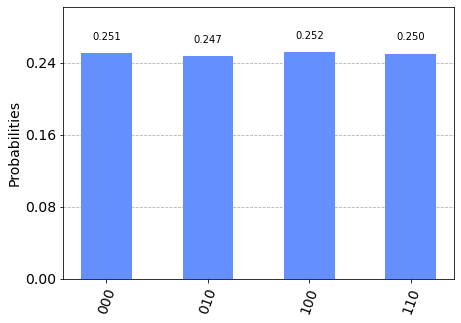

In [4]:
aersim = Aer.get_backend('aer_simulator') #set memory=True to see measurements
tqc = transpile(qc,aersim)
results = aersim.run(tqc,shots=10000).result()
plot_histogram(results.get_counts())

In [ ]:

provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
sevenqc = provider.backends(filters=lambda x: x.configuration().n_qubits == 7
                                    and not x.configuration().simulator
                                    and x.status().operational==True)
print(least_busy(sevenqc))
backend = least_busy(sevenqc)
tqc = transpile(qc,backend)
results = backend.run(tqc,shots=20000).result()